In [17]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import cartopy.crs as ccrs
from matplotlib.colors import LinearSegmentedColormap
import contextily as cx
import warnings
warnings.filterwarnings('ignore')

In [33]:
colors = ['blue', 'white', 'red']
n_bins = 100
cmap_name = 'blue_white_red'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

gis_path = r'F:/SEACAR_WQ_2024/GIS_Data/'
area_shortnames = {
    'Guana Tolomato Matanzas': 'GTM',
    'Estero Bay': 'EB',
    'Charlotte Harbor': 'CH',
    'Biscayne Bay': 'BB',
    'Big Bend Seagrasses':'BBS'
}

param_shortnames = {
    'Salinity': 'Sal_ppt',
    'Total Nitrogen': 'TN_mgl',
    'Dissolved Oxygen': 'DO_mgl',
    'Turbidity':'Turb_ntu',
    'Secchi Depth':'Secc_m',
    'Water Temperature':'T_c'
}
wb_list = ['BB', 'CH', 'EB', 'GTM']
para_list = ['DO_mgl', 'Sal_ppt', 'Turb_ntu', 'T_c']

In [18]:
dfCon = pd.read_csv(gis_path + 'OEAT_Continuous_WQ-2024-Feb-21.csv', low_memory=False)

In [26]:
dfCon_group = dfCon.groupby(["WaterBody","ParameterName","Latitude_DD","Longitude_DD"])["ResultValue"].mean().reset_index()

In [30]:
gdfCon_group = gpd.GeoDataFrame(dfCon_group,geometry=gpd.points_from_xy(dfCon_group["Longitude_DD"],dfCon_group["Latitude_DD"],crs="EPSG:4326")).to_crs("EPSG:3086")

In [34]:
gdfCon_group["Area_Ab"] = gdfCon_group['WaterBody'].map(area_shortnames)
gdfCon_group["Para_Ab"] = gdfCon_group['ParameterName'].map(param_shortnames)

In [39]:
for wb in wb_list:
    for para in para_list:
        df_used = gdfCon_group[(gdfCon_group["Area_Ab"]==str(wb))&(gdfCon_group["Para_Ab"]==str(para))]
        name = r'F:/SEACAR_WQ_2024/GIS_Data/temp/'+str(wb)+"_"+str(para)+"_con.shp"
        print(name)
        df_used.to_file(name)

F:/SEACAR_WQ_2024/GIS_Data/temp/BB_DO_mgl_con.shp
F:/SEACAR_WQ_2024/GIS_Data/temp/BB_Sal_ppt_con.shp
F:/SEACAR_WQ_2024/GIS_Data/temp/BB_Turb_ntu_con.shp
F:/SEACAR_WQ_2024/GIS_Data/temp/BB_T_c_con.shp
F:/SEACAR_WQ_2024/GIS_Data/temp/CH_DO_mgl_con.shp
F:/SEACAR_WQ_2024/GIS_Data/temp/CH_Sal_ppt_con.shp
F:/SEACAR_WQ_2024/GIS_Data/temp/CH_Turb_ntu_con.shp
F:/SEACAR_WQ_2024/GIS_Data/temp/CH_T_c_con.shp
F:/SEACAR_WQ_2024/GIS_Data/temp/EB_DO_mgl_con.shp
F:/SEACAR_WQ_2024/GIS_Data/temp/EB_Sal_ppt_con.shp
F:/SEACAR_WQ_2024/GIS_Data/temp/EB_Turb_ntu_con.shp
F:/SEACAR_WQ_2024/GIS_Data/temp/EB_T_c_con.shp
F:/SEACAR_WQ_2024/GIS_Data/temp/GTM_DO_mgl_con.shp
F:/SEACAR_WQ_2024/GIS_Data/temp/GTM_Sal_ppt_con.shp
F:/SEACAR_WQ_2024/GIS_Data/temp/GTM_Turb_ntu_con.shp
F:/SEACAR_WQ_2024/GIS_Data/temp/GTM_T_c_con.shp


In [13]:
def reproject_raster(src, dst_crs):
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    
    with rasterio.MemoryFile() as memfile:
        with memfile.open(**kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest
                )
        return memfile.open()

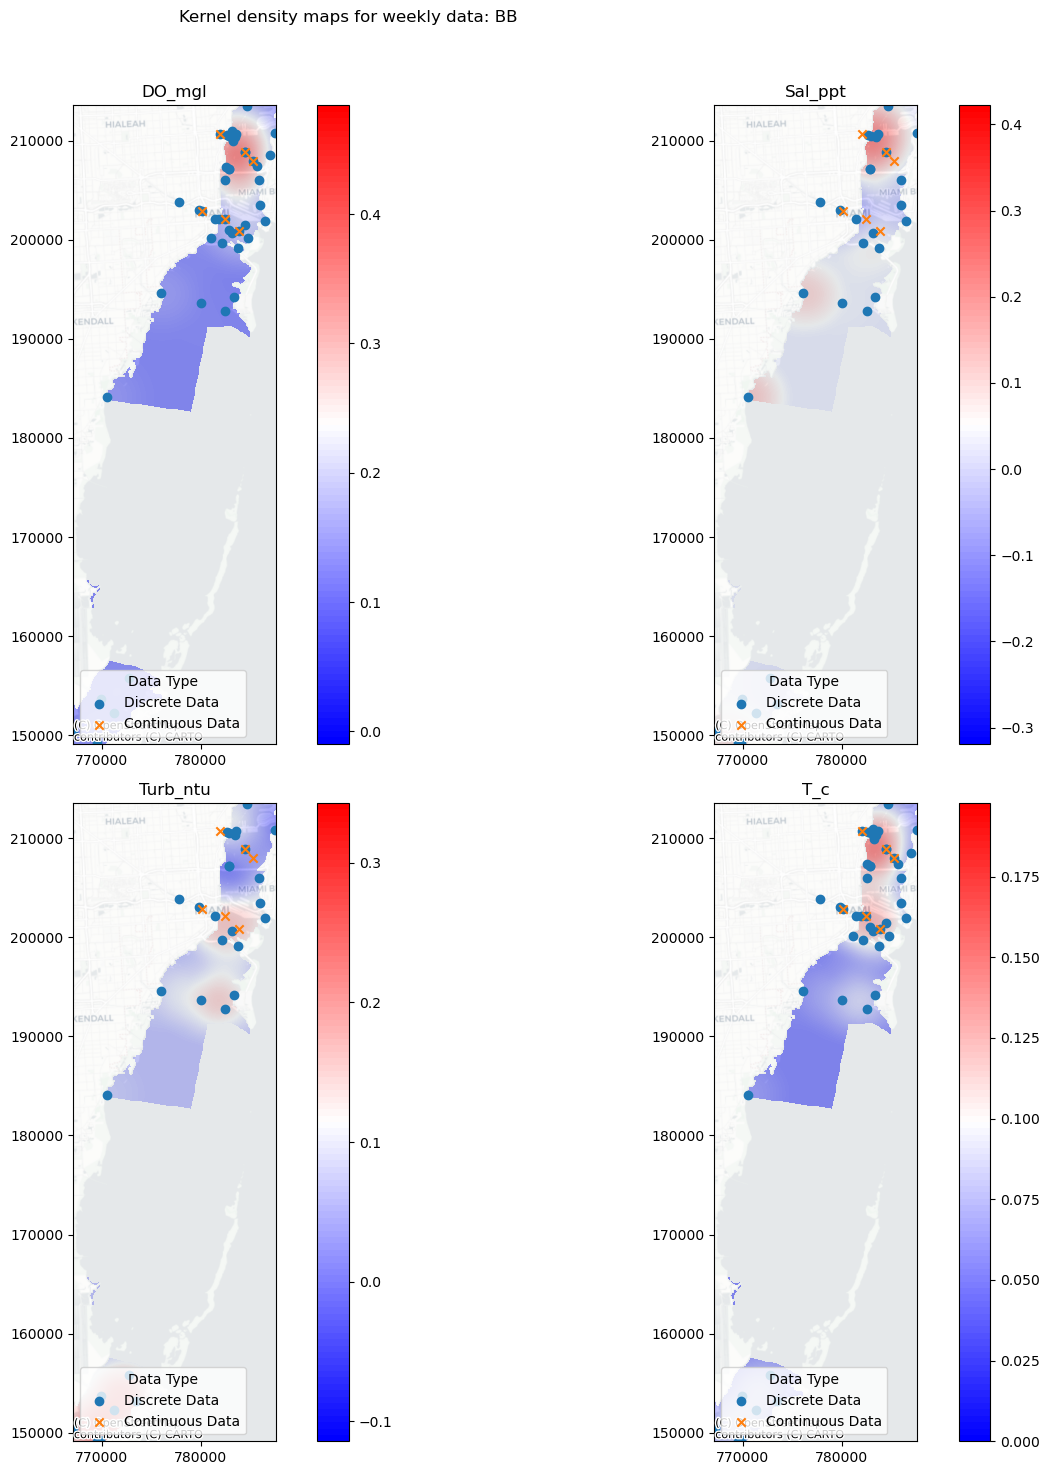

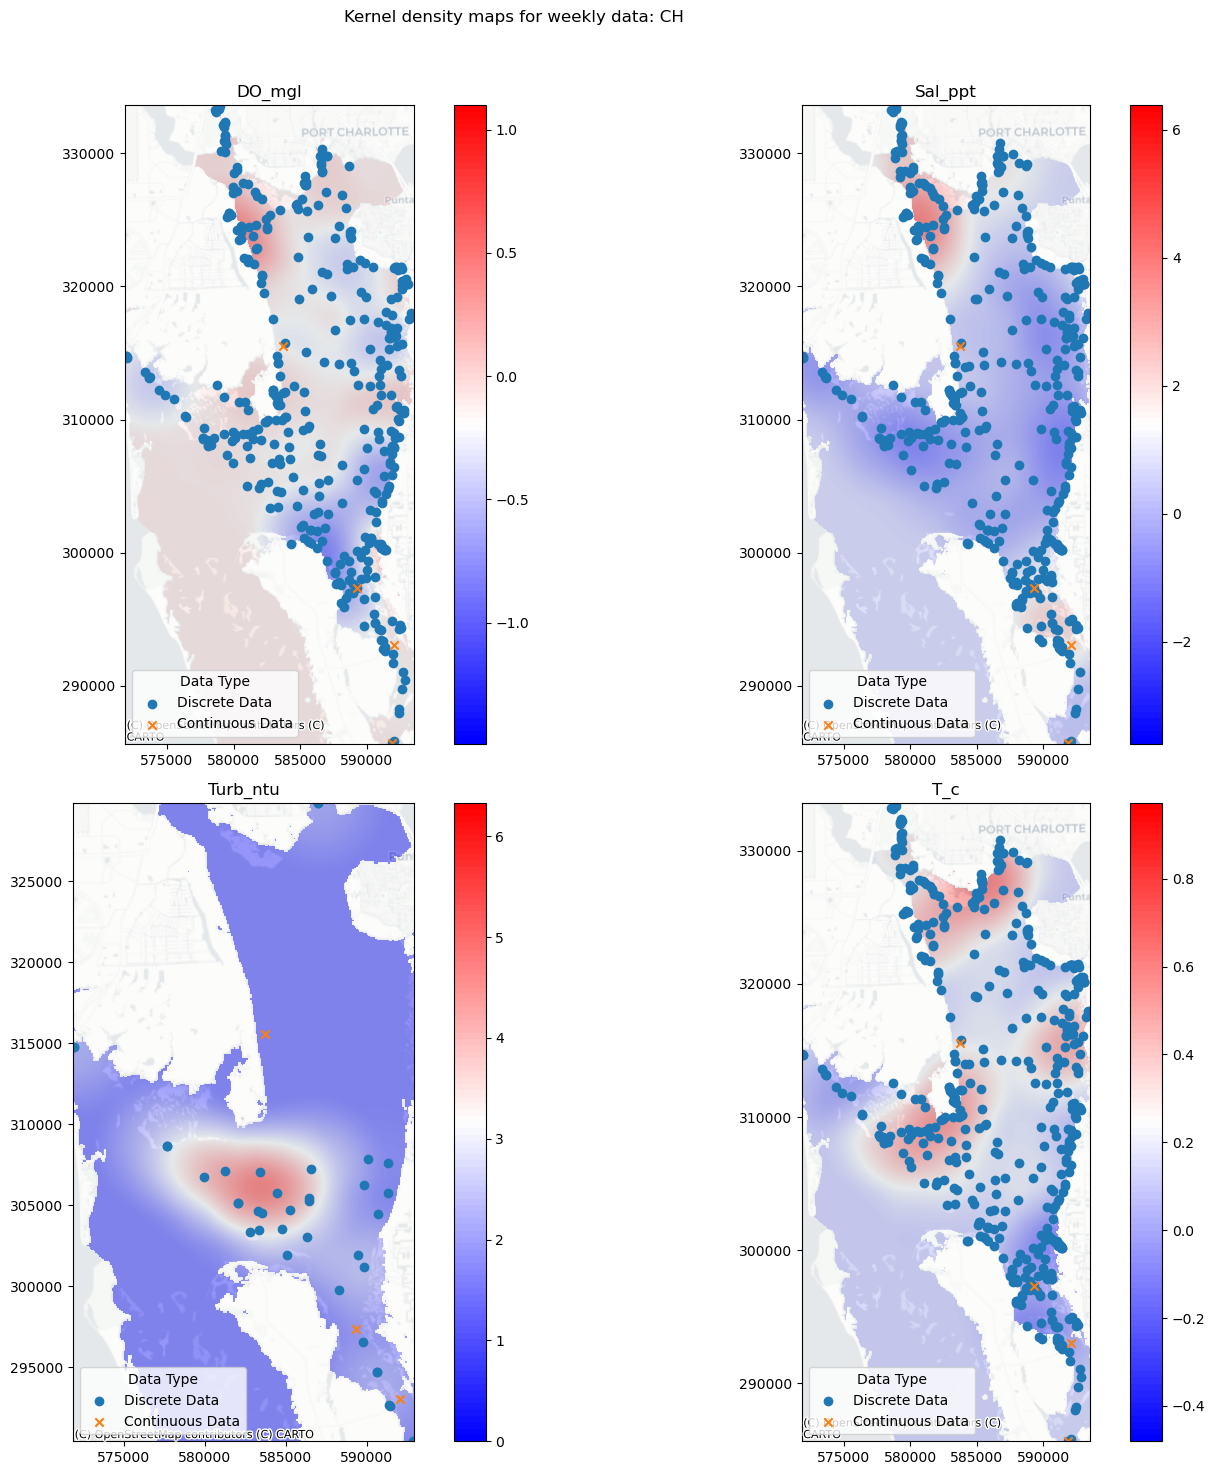

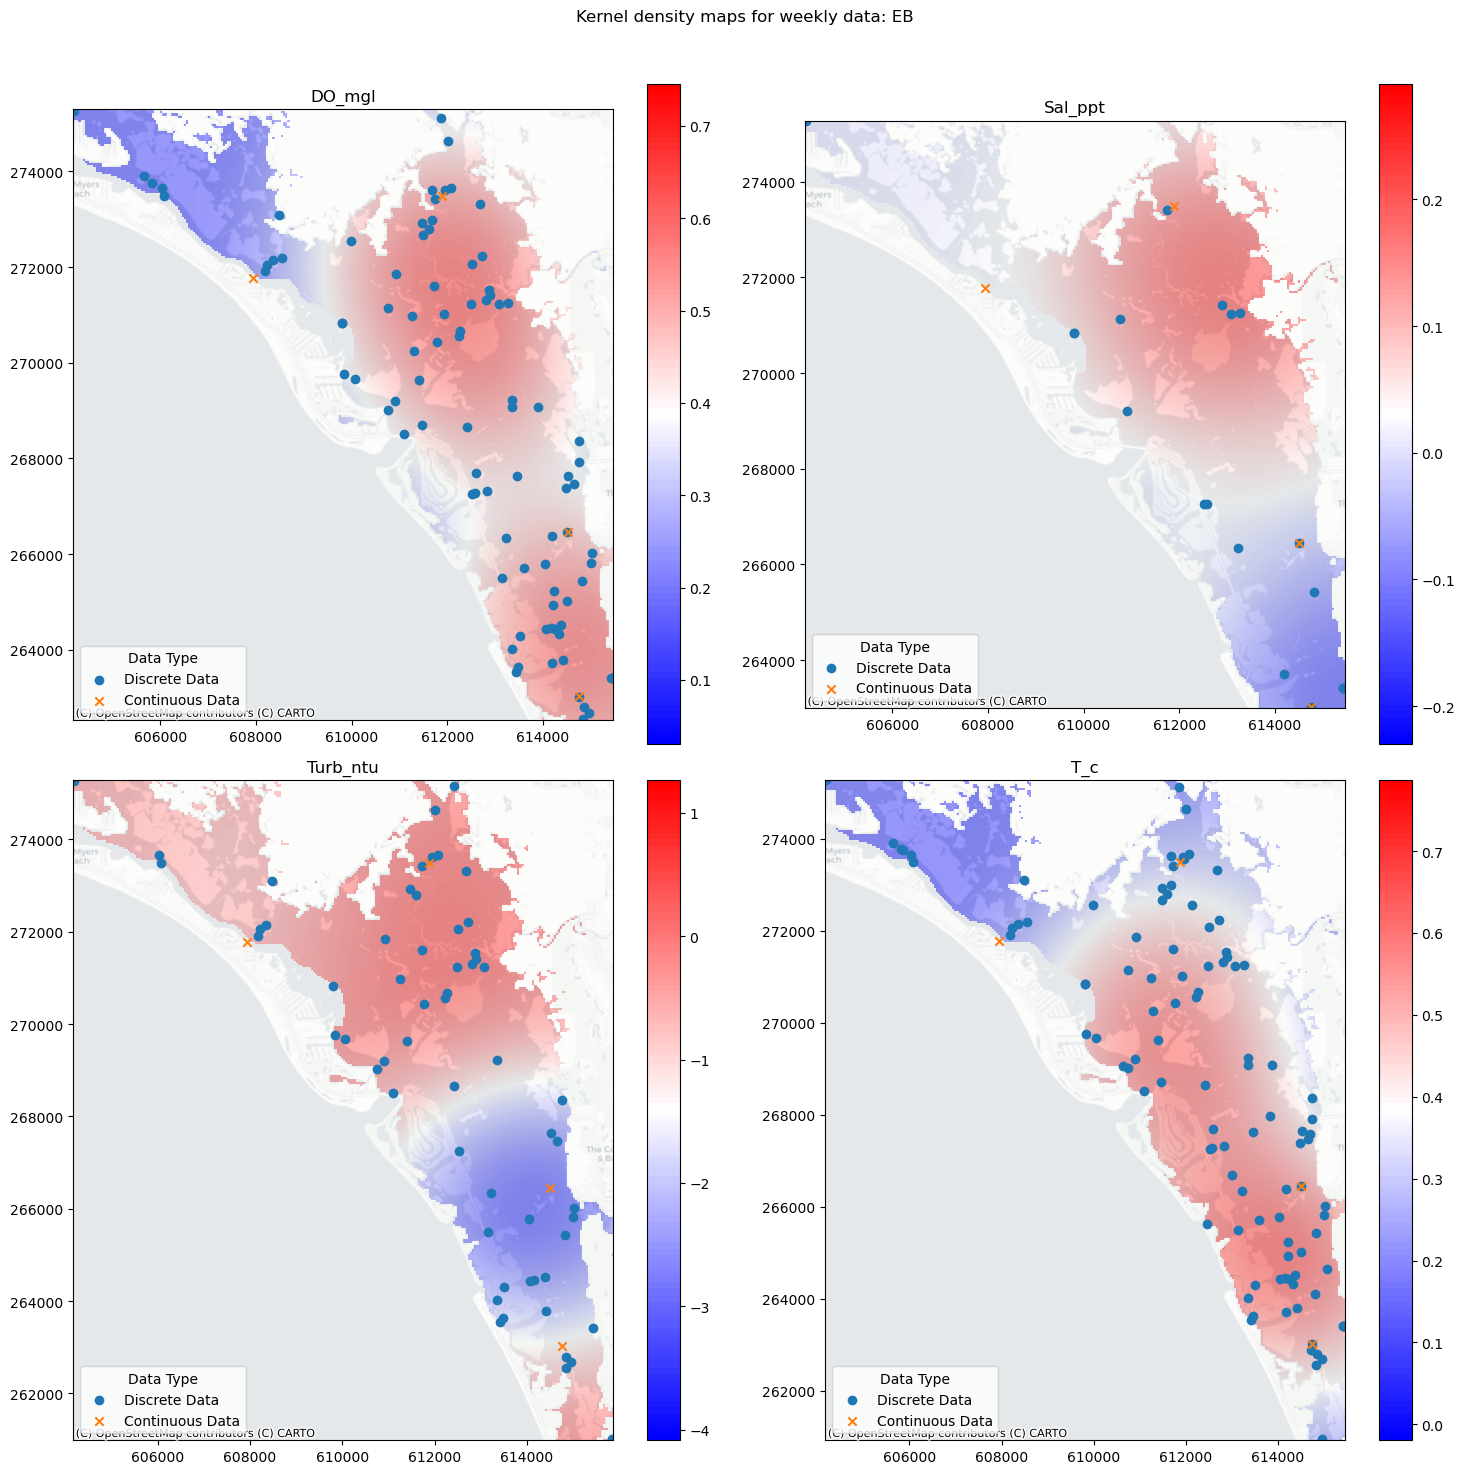

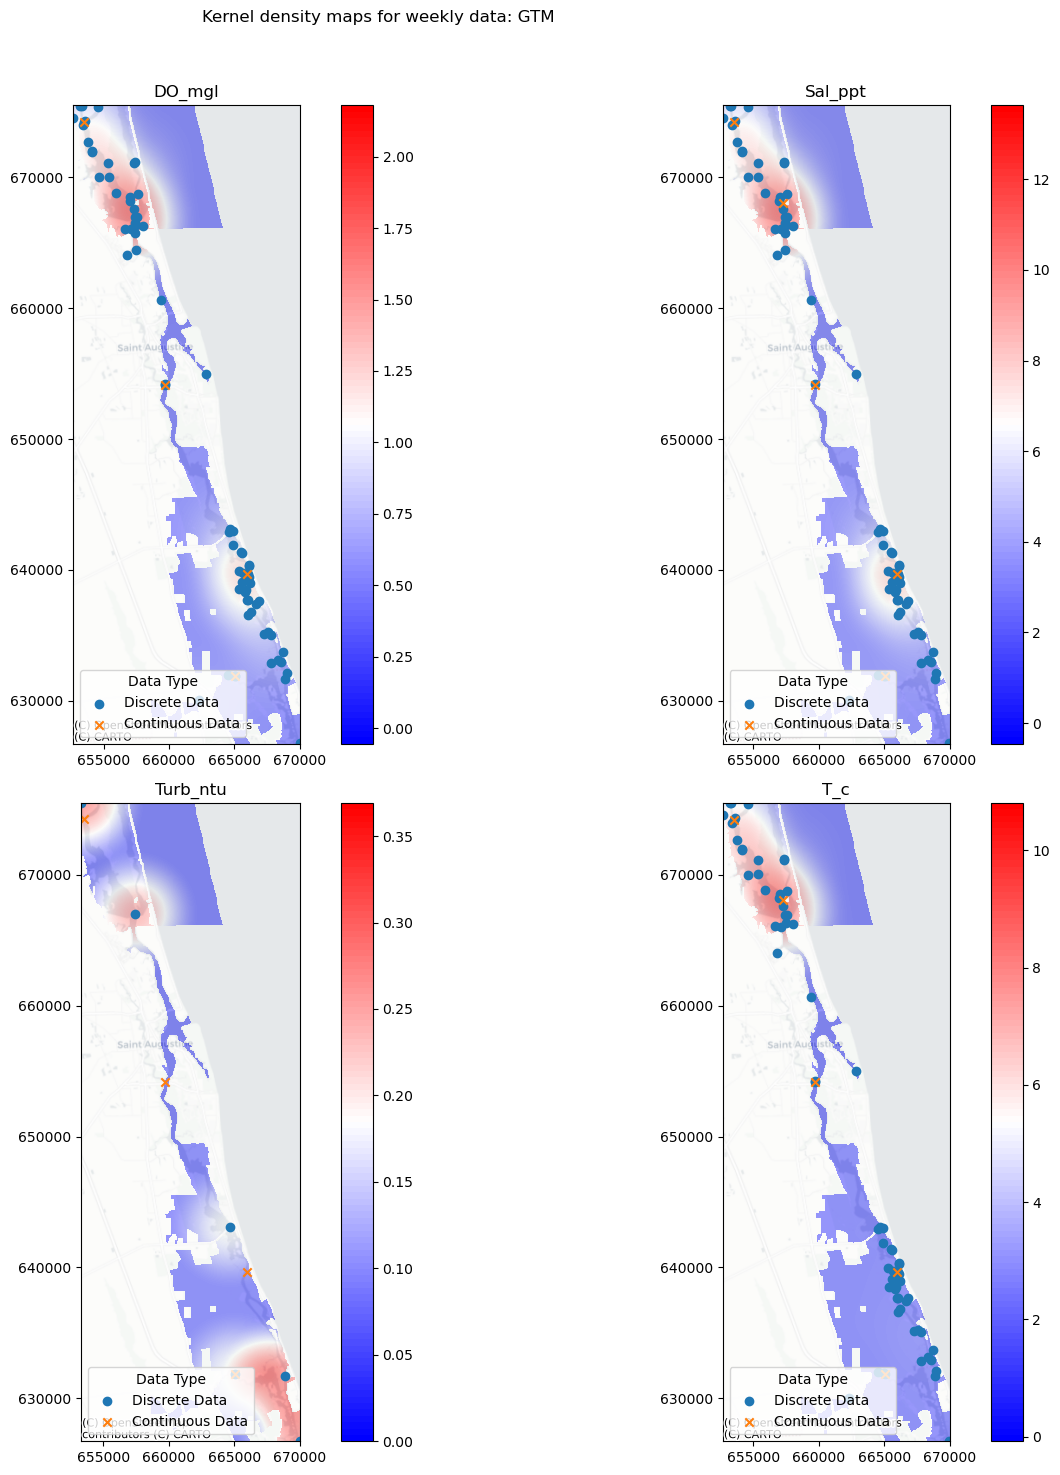

In [45]:
for wb in wb_list:
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle(f'Kernel density maps for weekly data: {wb}')

    for i, para in enumerate(para_list):
        ax = axs[i // 2, i % 2]  # Determine subplot position
        # Read in the shapefile
        barrier = gpd.read_file(gis_path + "managed_area_boundary/" + str(wb) + ".shp",crs="EPSG:3086")
        geometry = [feature["geometry"] for feature in barrier.__geo_interface__["features"]]
        name = str(wb) + "_" + str(para) + "_kd.tif"
        shpname = str(wb) + "_" + str(para) + ".shp"
        point_week = gpd.read_file(gis_path + "temp/week/" + shpname)
        point_week.plot(marker = "o",ax=ax,label="Discrete Data")
        conshpname = str(wb) + "_" + str(para) + "_con.shp"
        point_con = gpd.read_file(gis_path + "temp" + conshpname)
        point_con.plot(marker = "x",
                           edgecolors='blue',ax=ax,label="Continuous Data")
        ax.legend(title='Data Type',loc="lower left")
        # Open the raster file
        with rasterio.open(gis_path + "temp/week/" + name) as src:
            dst_crs = 'EPSG:3086'
            reprojected_src = reproject_raster(src, dst_crs)
            
            out_image, out_transform = mask(reprojected_src, geometry, crop=True)
            out_image = out_image[0]
            out_image = np.ma.masked_equal(out_image, reprojected_src.nodata)

            # Plot the image
            im = ax.imshow(out_image, cmap=cm,extent=rasterio.plot.plotting_extent(reprojected_src))
            fig.colorbar(im, ax=ax)
            ax.set_title(f'{para}')

            # Add basemap
            try:
                cx.add_basemap(ax,source=cx.providers.CartoDB.Positron,alpha=0.6, crs="EPSG:3086")
            except Exception as e:
                print(f"Error adding basemap: {e}")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

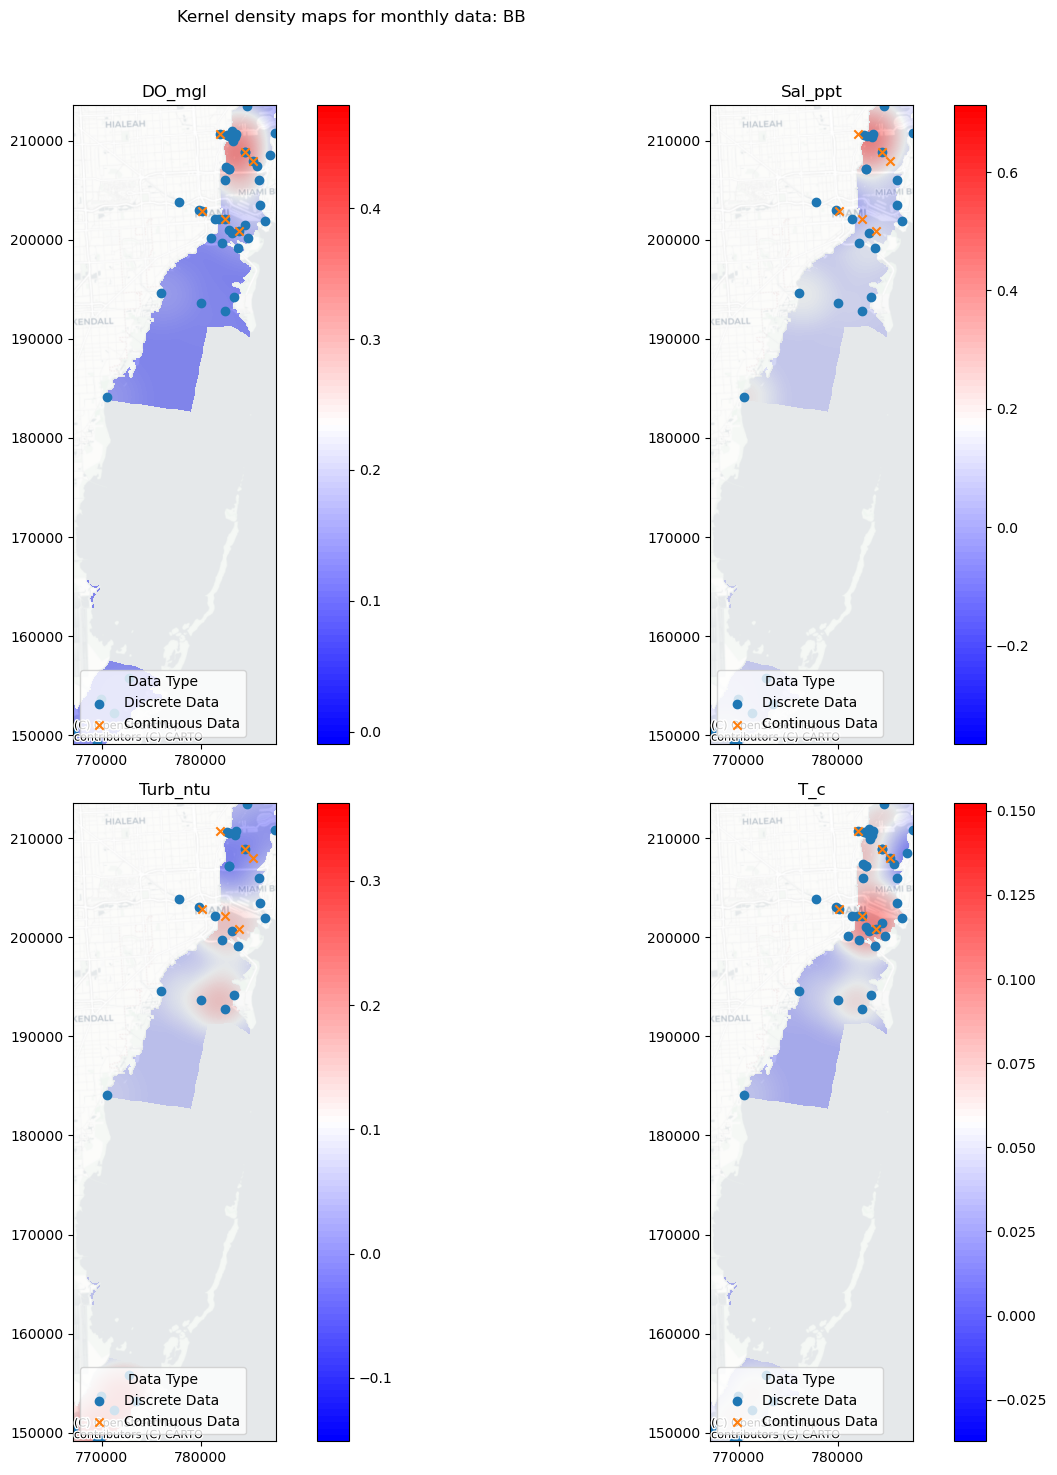

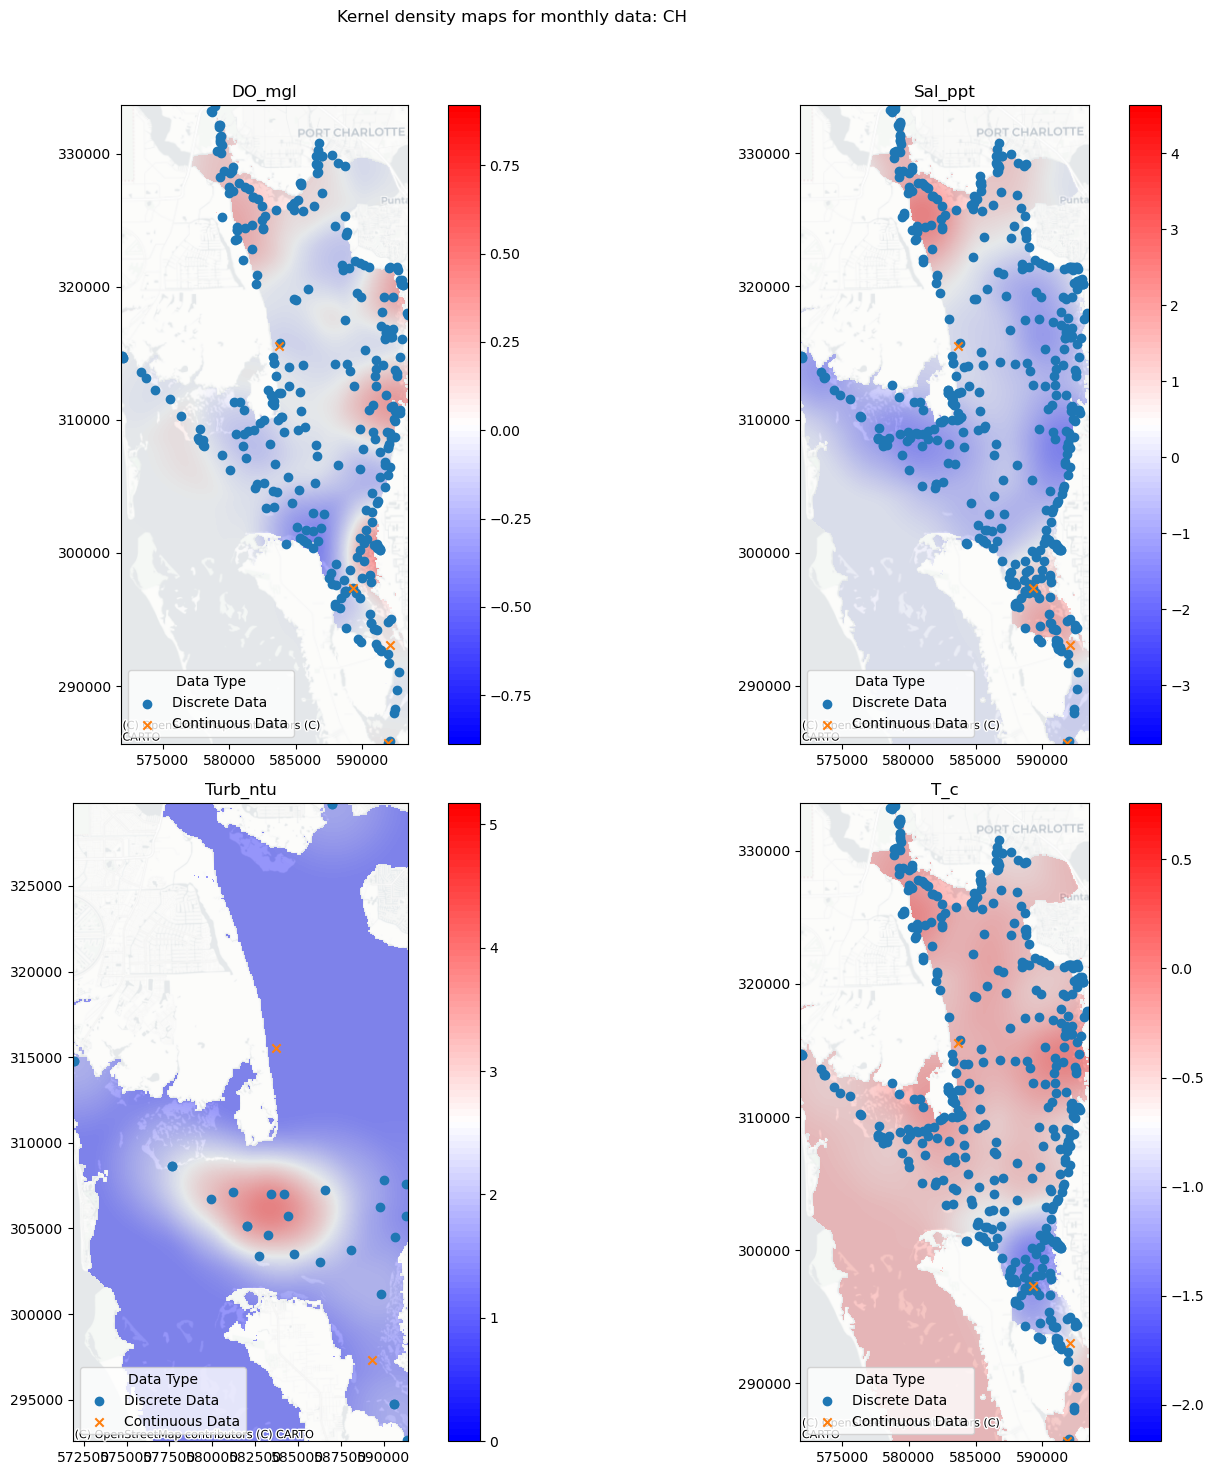

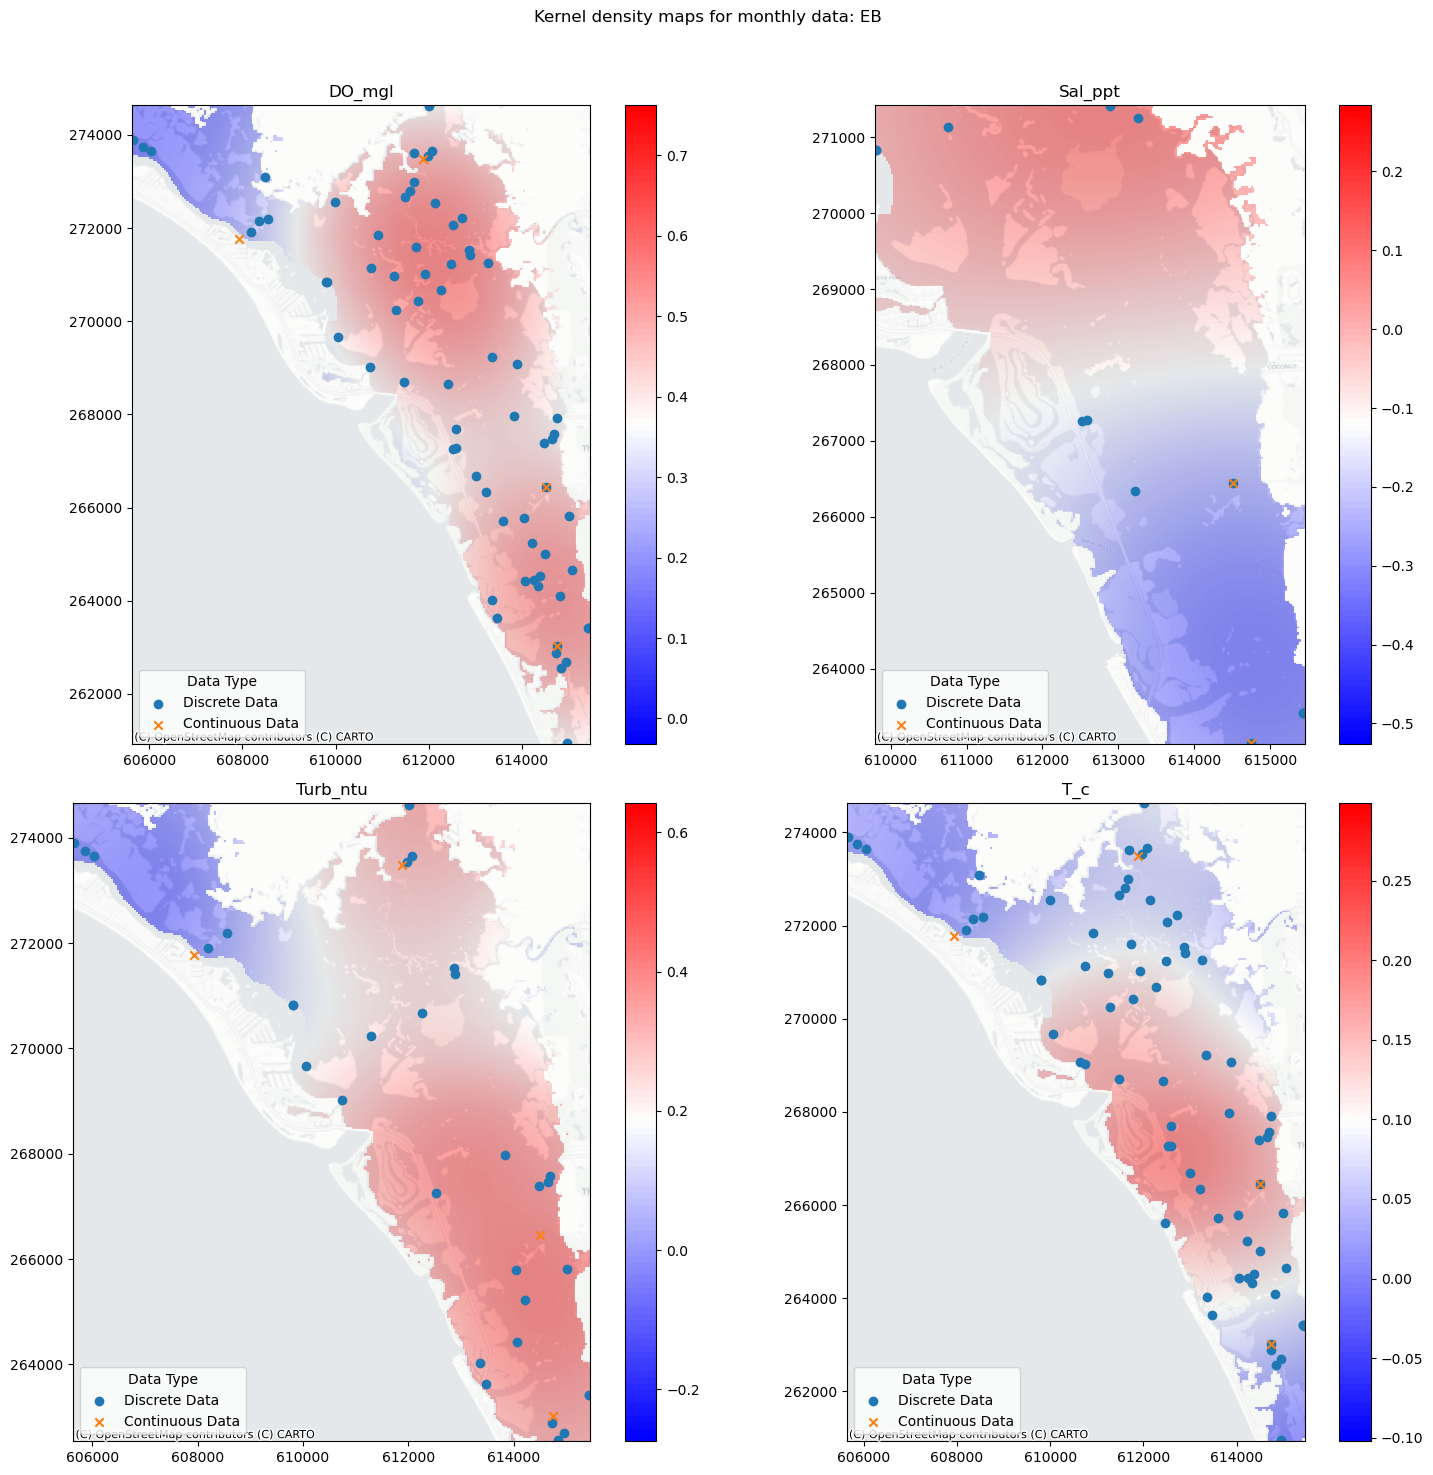

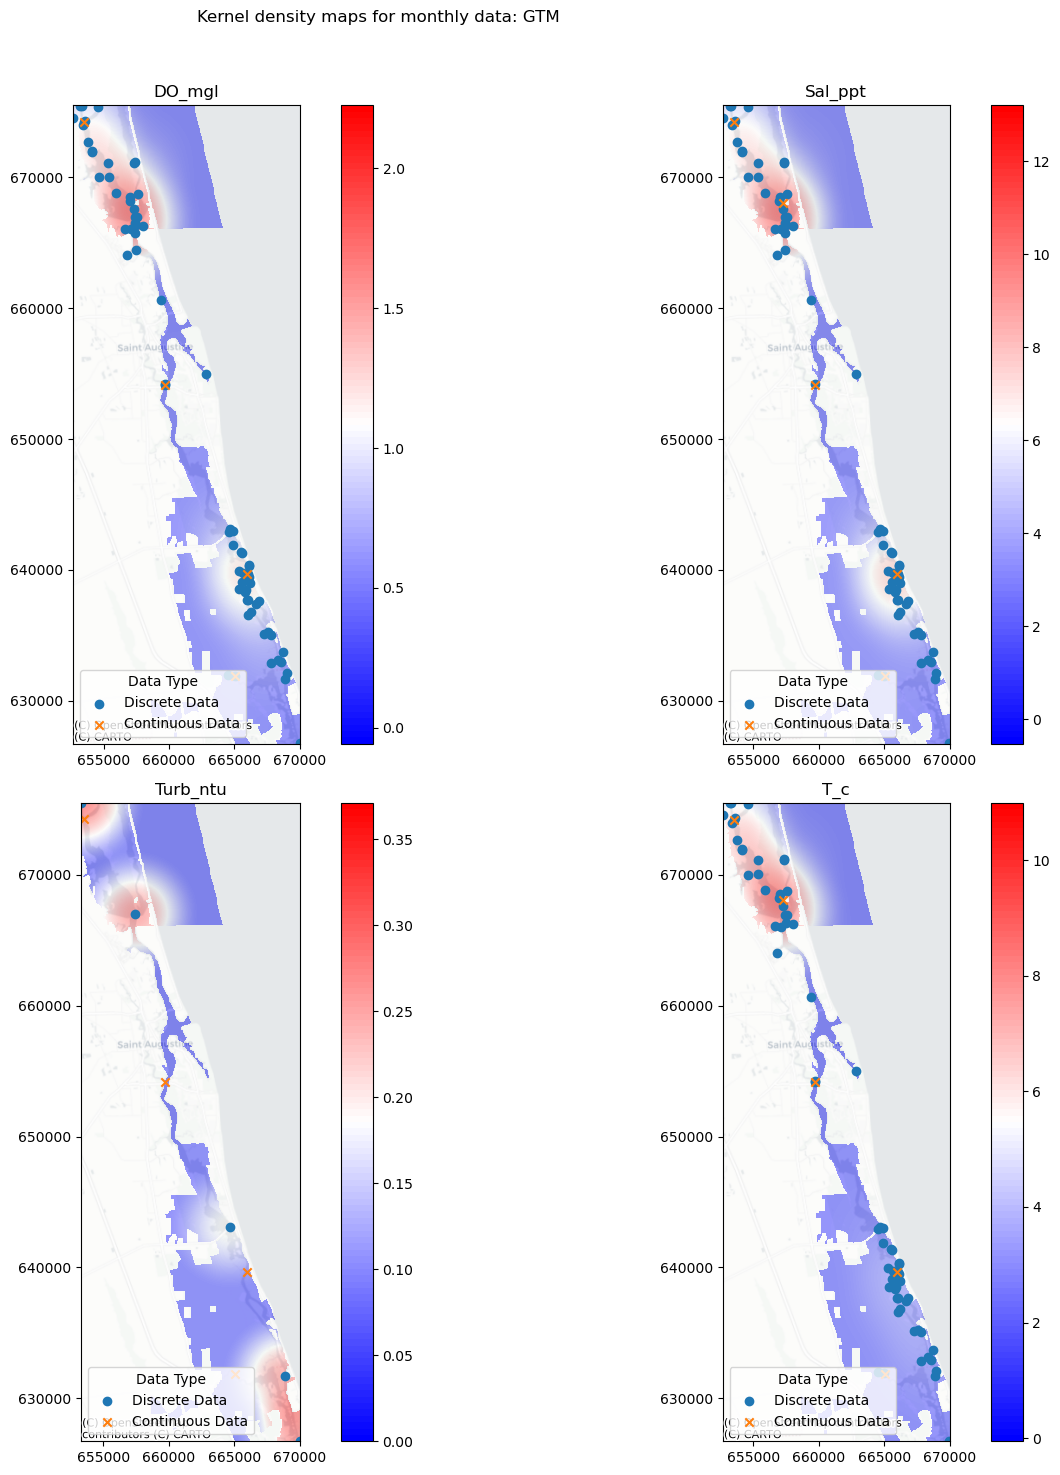

In [46]:
for wb in wb_list:
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle(f'Kernel density maps for monthly data: {wb}')

    for i, para in enumerate(para_list):
        ax = axs[i // 2, i % 2]  # Determine subplot position
        # Read in the shapefile
        barrier = gpd.read_file(gis_path + "managed_area_boundary/" + str(wb) + ".shp",crs="EPSG:3086")
        geometry = [feature["geometry"] for feature in barrier.__geo_interface__["features"]]
        name = str(wb) + "_" + str(para) + "_kd.tif"
        shpname = str(wb) + "_" + str(para) + ".shp"
        point_month = gpd.read_file(gis_path + "temp/month/" + shpname)
        point_month.plot(marker = "o",ax=ax,label="Discrete Data")
        conshpname = str(wb) + "_" + str(para) + "_con.shp"
        point_con = gpd.read_file(gis_path + "temp" + conshpname)
        point_con.plot(marker = "x",
                           edgecolors='blue',ax=ax,label="Continuous Data")
        ax.legend(title='Data Type',loc="lower left")
        # Open the raster file
        with rasterio.open(gis_path + "temp/month/" + name) as src:
            dst_crs = 'EPSG:3086'
            reprojected_src = reproject_raster(src, dst_crs)
            
            out_image, out_transform = mask(reprojected_src, geometry, crop=True)
            out_image = out_image[0]
            out_image = np.ma.masked_equal(out_image, reprojected_src.nodata)

            # Plot the image
            im = ax.imshow(out_image, cmap=cm,extent=rasterio.plot.plotting_extent(reprojected_src))
            fig.colorbar(im, ax=ax)
            ax.set_title(f'{para}')

            # Add basemap
            try:
                cx.add_basemap(ax,source=cx.providers.CartoDB.Positron,alpha=0.6, crs="EPSG:3086")
            except Exception as e:
                print(f"Error adding basemap: {e}")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()